# RMIA Implementation and Experiment

This notebook implements the **Ratio Membership Inference Attack (RMIA)** as described in the paper ["Low-Cost High-Power Membership Inference Attacks"](https://arxiv.org/html/2312.03262v3#S2).

## 1. Concept and Objective
**Objective**: To determine whether a specific data point (an image $x$ from CIFAR-10) was part of the training set of a target model (ResNet-18).

**Key Idea**: RMIA improves upon simple loss-based attacks by using a **Likelihood Ratio (LR)** test. It compares the probability of the data under the target model against its probability under a "reference" model (which represents the general population or "world" distribution).

### Core Formulas
1.  **Likelihood Ratio (LR)**:
    $$
    LR(x) = \frac{P(x | \theta_{target})}{P(x | \theta_{ref})}
    $$
    Where:
    *   $P(x | \theta_{target})$ is the confidence of the target model on the true class of $x$.
    *   $P(x | \theta_{ref})$ is the confidence of the reference model (trained on disjoint data) on $x$.

2.  **RMIA Score**:
    The attack doesn't just look at the raw LR. It checks how "exceptional" the LR of $x$ is compared to the LRs of random samples $z$ from the population.
    $$
    Score_{RMIA}(x) = P_{z \sim \mathcal{Z}}(LR(x) > LR(z))
    $$
    This is empirically calculated as the fraction of population samples $z$ that have a lower Likelihood Ratio than $x$ (i.e., the percentile rank).

## 2. Implementation Steps
1.  **Data Preparation**: Split CIFAR-10 into four disjoint sets:
    *   **Target Members (12.5k)**: Used to train the Target Model.
    *   **Reference Members (12.5k)**: Used to train the Reference Model.
    *   **Population $Z$ (12.5k)**: Used to compute the normalization statistics for the RMIA score.
    *   **Non-Members (10k)**: The official CIFAR-10 test set, used as the "ground truth" non-members for evaluation.

2.  **Model Training**:
    *   Define a ResNet-18 modified for CIFAR-10 (small kernel size, no initial maxpool).
    *   Train `Target Model` on Target Members.
    *   Train `Reference Model` on Reference Members.
    *   *Note: Weights are saved/loaded to avoid re-training.*

3.  **Attack Execution**:
    *   Calculate $LR(x) = \frac{P(x | \theta_{target})}{P(x | \theta_{ref})}$ : Pass **Target Members** through both models (target and reference models)
    *   Calculate $LR(z) = \frac{P(z | \theta_{target})}{P(z | \theta_{ref})}$ : Pass **Population ($Z$)**  through both models (target and reference models)
    *   Calculate RMIA Score: For each $x$, count how many $z$'s have a smaller ratio than it (calculate the percentile)
    *   Threshold: If Score > $\beta$ (e.g., 0.5), classify as Member

4.  **Evaluation**:
    *   Compute the Receiver Operating Characteristic (ROC) curve.
    *   Calculate Area Under the Curve (AUC) to measure attack performance (0.5 = random, 1.0 = perfect).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
import copy
import argparse
import random

# --- 0. Seed for Reproducibility ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")


In [2]:
# --- 1. Model Definition (ResNet-18 adapted for CIFAR-10) ---
# Standard ResNet18 is designed for ImageNet (224x224).
# For CIFAR-10 (32x32), we need to adjust the initial layers to avoid excessive downsampling.

def get_resnet18_cifar10(num_classes=10):
    # Load standard ResNet18
    model = torchvision.models.resnet18(weights=None)
    
    # Modify the first convolution layer
    # Original: nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # CIFAR-10: Kernel size 3, stride 1, padding 1 is better to preserve spatial dim
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    
    # Remove the first MaxPool layer
    # Original: nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    # CIFAR-10: We don't want to downsample this early
    model.maxpool = nn.Identity()
    
    # Modify the fully connected layer for 10 classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

# --- 2. Helper Functions ---

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

def train_model(model, train_loader, test_loader=None, epochs=20, lr=0.1, device="cpu", model_name="model"):
    print(f"Training {model_name} on {device}...")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        train_acc = 100.*correct/total
        scheduler.step()

        test_acc_str = ""
        if test_loader:
            model.eval()
            test_correct = 0
            test_total = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = outputs.max(1)
                    test_total += labels.size(0)
                    test_correct += predicted.eq(labels).sum().item()
            test_acc = 100.*test_correct/test_total
            test_acc_str = f" Test Acc: {test_acc:.2f}%"

        print(f"  Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f} Train Acc: {train_acc:.2f}%{test_acc_str}")
    
    model.eval()
    return model

def get_probabilities(model, loader, device):
    """
    Returns the probabilities of the TRUE class for each sample.
    """
    model.eval()
    model.to(device)
    probs = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            softmax_scores = torch.softmax(outputs, dim=1)
            
            # Select the probability of the true class
            true_class_probs = softmax_scores.gather(1, labels.view(-1, 1)).squeeze()
            probs.extend(true_class_probs.cpu().numpy())
            
    return np.array(probs)

In [3]:
# --- 3. Main Experiment ---

set_seed(42)

data_dir = "./data"
epochs = 20
batch_size = 128

device = get_device()
print(f"Using device: {device}")

# Data Preparation
print("Preparing Data...")
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load Full CIFAR-10
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
# Use testset for evaluation/non-members
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

# Split Trainset
# Total 50k. 
# Target Members: 12.5k
# Reference Train: 12.5k (To train the reference model)
# Population Z: 12.5k (Used for RMIA normalization)
# Unused: 12.5k

indices = np.arange(len(trainset))
np.random.shuffle(indices)

idx_target = indices[:12500]
idx_ref = indices[12500:25000]
idx_pop = indices[25000:37500]

# We will use the official test set as "Non-Members" for the attack evaluation
# to ensure they are strictly out-of-distribution of training.

# Create Subsets
# Note: For evaluation (computing probs), we should use transform_test (no aug)
# So we need a version of trainset with test transforms
trainset_eval = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=False, transform=transform_test)

ds_target_train = Subset(trainset, idx_target)
ds_ref_train = Subset(trainset, idx_ref)

ds_target_eval = Subset(trainset_eval, idx_target) # Members (evaluated without aug)
ds_pop_eval = Subset(trainset_eval, idx_pop)       # Population Z
ds_non_member_eval = testset                       # Non-Members (Test set)

# Loaders: no shuffle to get the same result in different runs
dl_target_train = DataLoader(ds_target_train, batch_size=batch_size, shuffle=False)
dl_ref_train = DataLoader(ds_ref_train, batch_size=batch_size, shuffle=False)

dl_target_eval = DataLoader(ds_target_eval, batch_size=batch_size, shuffle=False)
dl_non_member_eval = DataLoader(ds_non_member_eval, batch_size=batch_size, shuffle=False)
dl_pop_eval = DataLoader(ds_pop_eval, batch_size=batch_size, shuffle=False)

Random seed set to 42
Using device: cpu
Preparing Data...


c:\Users\Administratör\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datasets\cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


In [4]:

# --- Train Target Model ---
print("\n--- Training Target Model ---")
target_model = get_resnet18_cifar10()
target_model_path = "target_model.pth"
if os.path.exists(target_model_path):
    print(f"Loading Target Model from {target_model_path}...")
    target_model.load_state_dict(torch.load(target_model_path, map_location=device))
    target_model.to(device)
    target_model.eval()
else:
    target_model = train_model(target_model, dl_target_train, test_loader=dl_non_member_eval, epochs=epochs, device=device, model_name="Target Model")
    torch.save(target_model.state_dict(), target_model_path)
    print(f"Saved Target Model to {target_model_path}")

# --- Train Reference Model ---
print("\n--- Training Reference Model ---")
# In a real attack, you might use multiple reference models. We use 1 for demonstration.
ref_model = get_resnet18_cifar10()
ref_model_path = "ref_model.pth"
if os.path.exists(ref_model_path):
    print(f"Loading Reference Model from {ref_model_path}...")
    ref_model.load_state_dict(torch.load(ref_model_path, map_location=device))
    ref_model.to(device)
    ref_model.eval()
else:
    ref_model = train_model(ref_model, dl_ref_train, test_loader=dl_non_member_eval, epochs=epochs, device=device, model_name="Reference Model")
    torch.save(ref_model.state_dict(), ref_model_path)
    print(f"Saved Reference Model to {ref_model_path}")



--- Training Target Model ---
Loading Target Model from target_model.pth...

--- Training Reference Model ---
Loading Reference Model from ref_model.pth...


In [5]:

# --- Perform RMIA Attack ---
print("\n--- Computing Probabilities ---")

# P(x | theta_target)
prob_target_members = get_probabilities(target_model, dl_target_eval, device)
print("prob_target_members", prob_target_members.size)
# P(x'| theta_target)
prob_target_non_members = get_probabilities(target_model, dl_non_member_eval, device)
print("prob_target_non_members", prob_target_non_members.size)
# P(z | theta_target)
prob_target_z = get_probabilities(target_model, dl_pop_eval, device)
print("prob_target_z", prob_target_z.size)
# P(x | theta_ref) -> approximates P(x)
prob_ref_members = get_probabilities(ref_model, dl_target_eval, device)
print("prob_ref_members", prob_ref_members.size)
# P(x' | theta_ref)
prob_ref_non_members = get_probabilities(ref_model, dl_non_member_eval, device)
print("prob_ref_non_members", prob_ref_non_members.size)
# P(z | theta_ref)
prob_ref_z = get_probabilities(ref_model, dl_pop_eval, device)
print("prob_ref_z", prob_ref_z.size)



--- Computing Probabilities ---
prob_target_members 12500
prob_target_non_members 10000
prob_target_z 12500
prob_ref_members 12500
prob_ref_non_members 10000
prob_ref_z 12500


In [6]:

print("\n--- Calculating RMIA Scores ---")

# Calculate Likelihood Ratios: LR(x) = P(x|Target) / P(x|Ref)
# Adding epsilon to avoid division by zero
epsilon = 1e-10
# LR(x)
ratio_members = prob_target_members / (prob_ref_members + epsilon)
# LR(z)
ratio_z = prob_target_z / (prob_ref_z + epsilon)
# LR(non-member)
ratio_non_members = prob_target_non_members / (prob_ref_non_members + epsilon)

# RMIA Score(x) = Pr( LR(x) > LR(z) )
# For each x, we calculate what fraction of z samples have a lower ratio.
# This is equivalent to the rank or percentile.

def calculate_rmia_score(ratios_eval, ratios_population):
    scores = []
    # Sort population ratios for binary search (faster) or just broadcasting
    # Using broadcasting for clarity
    ratios_population = np.array(ratios_population)
    for r in ratios_eval:
        # Fraction of population ratios that are strictly smaller than r
        # (or <=, depending on strictness. The paper uses > gamma)
        score = np.mean(r > ratios_population)
        scores.append(score)
    return np.array(scores)
# list of RMIA score: 12500 scores, one for each image in the member set
rmia_scores_members = calculate_rmia_score(ratio_members, ratio_z)
print("rmia_scores_members", rmia_scores_members.size)
# list of RMIA score: 10000 scores, one for each image in the non-member set
rmia_scores_non_members = calculate_rmia_score(ratio_non_members, ratio_z)
print("rmia_scores_non_members", rmia_scores_non_members.size)



--- Calculating RMIA Scores ---
rmia_scores_members 12500
rmia_scores_non_members 10000


y_true 22500
y_scores 22500
fpr 6406
tpr 6406
thresholds 6406

RMIA Attack Results:
AUC: 0.7020
ROC curve saved to rmia_roc_curve.png


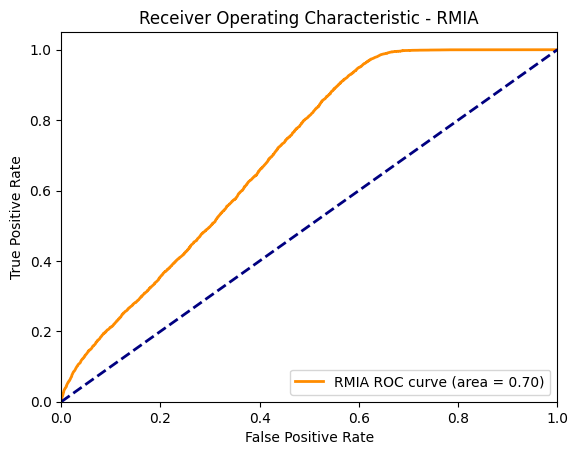

In [7]:

# --- Evaluation ---
# ground truth: a list of 12500+10000 with 12500 value of 1 for members and 10000 value of 0 for non-member
y_true = np.concatenate([np.ones_like(rmia_scores_members), np.zeros_like(rmia_scores_non_members)])
print("y_true", y_true.size)
# RMIA scores: 12500 scores for members and 10000 score for non-members
y_scores = np.concatenate([rmia_scores_members, rmia_scores_non_members])
print("y_scores", y_scores.size)
# no constant threshold but each of the socre is used as a potential threshold
# for each potential threshold, 
#   classify x is a member if y_score(x) > the threshold and vice versa.
#   compare the classification result with the y_true, count no of TP, FP, TN, FN
#   calculate the TPR = TP/(TP+FN) and FPR = FP/(FP+TN)
# the roc_curve fnc performs all above tasks for the moving thresholds
#   fpr and tpr is a list of fpr and tpr with the size of 12500+10000 each
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
print("fpr", fpr.size)
print("tpr", tpr.size)
print("thresholds", thresholds.size)
roc_auc = auc(fpr, tpr)

print(f"\nRMIA Attack Results:")
print(f"AUC: {roc_auc:.4f}")

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'RMIA ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - RMIA')
plt.legend(loc="lower right")
plt.savefig('rmia_roc_curve.png')
print("ROC curve saved to rmia_roc_curve.png")

## Extended experiment: RMIA with 2 reference models


--- Training Reference Model 2 ---
Loading Reference Model 2 from ref_model_2.pth...

--- Computing Probabilities for Ref Model 2 ---

--- Calculating RMIA Scores (2 Ref Models) ---

RMIA Attack Results (2 Ref Models):
AUC: 0.7390
Comparison ROC curve saved to rmia_roc_comparison.png


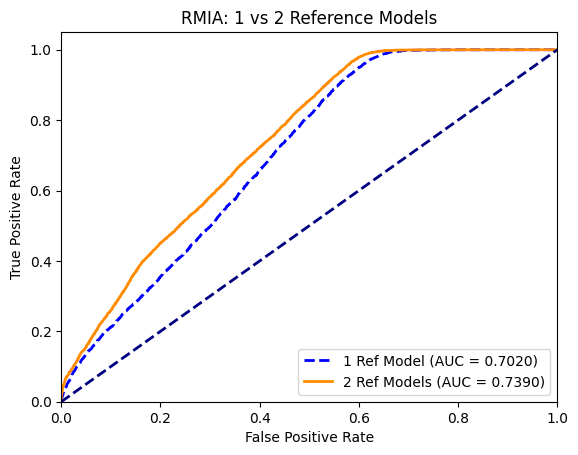

In [8]:
# --- 4. Extended Experiment: 2 Reference Models ---

# 4.1 Data for Reference Model 2
# We use the remaining unused training data (indices 37500 to 50000)
idx_ref2 = indices[37500:]
ds_ref2_train = Subset(trainset, idx_ref2)
dl_ref2_train = DataLoader(ds_ref2_train, batch_size=batch_size, shuffle=False)

# 4.2 Train Reference Model 2
print("\n--- Training Reference Model 2 ---")
ref_model_2 = get_resnet18_cifar10()
ref_model_2_path = "ref_model_2.pth"

if os.path.exists(ref_model_2_path):
    print(f"Loading Reference Model 2 from {ref_model_2_path}...")
    ref_model_2.load_state_dict(torch.load(ref_model_2_path, map_location=device))
    ref_model_2.to(device)
    ref_model_2.eval()
else:
    ref_model_2 = train_model(ref_model_2, dl_ref2_train, test_loader=dl_non_member_eval, epochs=epochs, device=device, model_name="Reference Model 2")
    torch.save(ref_model_2.state_dict(), ref_model_2_path)
    print(f"Saved Reference Model 2 to {ref_model_2_path}")

# 4.3 Compute Probabilities for Ref Model 2
print("\n--- Computing Probabilities for Ref Model 2 ---")
prob_ref2_members = get_probabilities(ref_model_2, dl_target_eval, device)
prob_ref2_non_members = get_probabilities(ref_model_2, dl_non_member_eval, device)
prob_ref2_z = get_probabilities(ref_model_2, dl_pop_eval, device)

# 4.4 Ensemble Reference Probabilities (Average)
# P(x | theta_ref_ensemble) = (P(x | theta_ref1) + P(x | theta_ref2)) / 2
prob_ref_members_ens = (prob_ref_members + prob_ref2_members) / 2
prob_ref_non_members_ens = (prob_ref_non_members + prob_ref2_non_members) / 2
prob_ref_z_ens = (prob_ref_z + prob_ref2_z) / 2

# 4.5 Calculate New Ratios
# LR(x) = P(x|Target) / P(x|Ref_Ensemble)
ratio_members_ens = prob_target_members / (prob_ref_members_ens + epsilon)
ratio_non_members_ens = prob_target_non_members / (prob_ref_non_members_ens + epsilon)
ratio_z_ens = prob_target_z / (prob_ref_z_ens + epsilon)

# 4.6 Calculate RMIA Scores
print("\n--- Calculating RMIA Scores (2 Ref Models) ---")
rmia_scores_members_ens = calculate_rmia_score(ratio_members_ens, ratio_z_ens)
rmia_scores_non_members_ens = calculate_rmia_score(ratio_non_members_ens, ratio_z_ens)

# 4.7 Evaluation
y_true_ens = np.concatenate([np.ones_like(rmia_scores_members_ens), np.zeros_like(rmia_scores_non_members_ens)])
y_scores_ens = np.concatenate([rmia_scores_members_ens, rmia_scores_non_members_ens])

fpr_ens, tpr_ens, thresholds_ens = roc_curve(y_true_ens, y_scores_ens)
roc_auc_ens = auc(fpr_ens, tpr_ens)

print(f"\nRMIA Attack Results (2 Ref Models):")
print(f"AUC: {roc_auc_ens:.4f}")

# Plot Comparison
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, linestyle='--', label=f'1 Ref Model (AUC = {roc_auc:.4f})')
plt.plot(fpr_ens, tpr_ens, color='darkorange', lw=2, label=f'2 Ref Models (AUC = {roc_auc_ens:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RMIA: 1 vs 2 Reference Models')
plt.legend(loc="lower right")
plt.savefig('rmia_roc_comparison.png')
print("Comparison ROC curve saved to rmia_roc_comparison.png")

---

# TASK 2: Defending Against RMIA with Holographically Reduced Representations (HRR)

## Concept: How HRR Protects Against RMIA

**Problem**: RMIA succeeds because an attacker can train a reference model on similar data and compare it to the target model.

**Solution - HRR**: Use a **secret key** to transform all training data in a non-invertible way (without the key). 
- Target model is trained on transformed data: $x' = f_s(x)$ where $s$ is the secret key
- An attacker without the key cannot create transformed data that matches the training distribution
- Without matching training data, the reference model cannot approximate the target model's behavior
- RMIA fails because $LR(x) = P(x'|target) / P(x|ref)$ compares incompatible distributions

## Implementation Strategy
1. Generate a random projection matrix as the secret key $s$
2. Transform CIFAR-10 images using this key (flattened images → random projection → reshape)
3. Train a new "defended" target model on transformed data
4. Keep the reference model unchanged (attacker trains on untransformed data)
5. Perform RMIA attack and observe reduced effectiveness

In [9]:
print("\n" + "="*80)
print("TASK 2: HRR DEFENSE AGAINST RMIA")
print("="*80)

# ============================================================================
# HOLOGRAPHICALLY REDUCED REPRESENTATIONS (HRR) - DEFENSE MECHANISM
# ============================================================================
# 
# CORE IDEA: 
#   Instead of training the target model on ORIGINAL data, we train it on
#   TRANSFORMED data using a SECRET KEY. This breaks the attack because:
#   
#   1. Attacker has NO access to the secret key
#   2. Attacker CANNOT generate transformed data matching the defense
#   3. Reference model (attacker's) uses original data, not transformed data
#   4. Mismatch between distributions → Attack fails (AUC → 0.5)
#
# MATHEMATICAL INSIGHT:
#   Normal RMIA: LR(x) = P(x | θ_target) / P(x | θ_ref)
#               Target trained on: X
#               Reference trained on: X (similar distribution)
#               Result: LR differentiates members well
#
#   With HRR:   LR(x) = P(x | θ_target_hrr) / P(x | θ_ref)
#               Target trained on: HRR(X) = X @ secret_matrix
#               Reference trained on: X (original, attacker doesn't know secret)
#               Result: Incompatible distributions → LR is random
#
# ============================================================================

class HRRTransform:
    """
    Holographically Reduced Representations (HRR) Defense Transform
    
    This class implements a privacy-preserving transformation using random projections.
    The key idea: project high-dimensional data onto a lower-dimensional subspace
    using a RANDOM matrix that acts as a SECRET KEY.
    
    Why it works for defense:
    - Without knowing the random matrix, an attacker cannot recreate the transformed data
    - The transformation is deterministic (same input → same output)
    - But UNKNOWN transformation matrix makes it asymmetrically hard to reverse
    
    Args:
        input_dim (int): Original flattened dimension (3*32*32 = 3072 for CIFAR-10)
        hidden_dim (int): Dimension of reduced representation (1024 is a good balance)
        seed (int): Random seed to generate reproducible secret keys
    """
    
    def __init__(self, input_dim=3072, hidden_dim=1024, seed=42):
        """
        Initialize HRR transformation with a random projection matrix.
        
        Parameters:
            input_dim: 3072 (for CIFAR-10: 3 channels * 32 * 32 = 3072 dimensions)
            hidden_dim: 1024 (compress to 1024 dimensions, keeping ~33% information)
            seed: For reproducibility (but SECRET in real deployment)
        """
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seed = seed
        
        # ===== CREATE SECRET PROJECTION MATRIX =====
        # This matrix IS THE SECRET KEY that defenders have but attackers don't
        np.random.seed(seed)
        # Create random matrix: shape (input_dim, hidden_dim) = (3072, 1024)
        self.secret_key = np.random.randn(input_dim, hidden_dim).astype(np.float32)
        
        # Normalize each column (dimension) to unit norm for numerical stability
        # This prevents some dimensions from dominating others during projection
        self.secret_key = self.secret_key / np.linalg.norm(self.secret_key, axis=0, keepdims=True)
        
        print(f"HRR Secret Key generated: shape {self.secret_key.shape} (3072 → 1024 dimensions)")
        print(f"  This secret matrix is what defenders use in training.")
        print(f"  Attackers do NOT have access to this matrix!")
    
    def transform(self, x):
        """
        Apply HRR transformation to a batch of images.
        
        Transformation pipeline:
        1. Flatten: (batch, 3, 32, 32) → (batch, 3072)
        2. Project: (batch, 3072) @ (3072, 1024) → (batch, 1024)
        3. Reshape: Pad back to (batch, 3072) and reshape to (batch, 3, 32, 32)
        
        Parameters:
            x: numpy array of shape (batch_size, 3, 32, 32)
            
        Returns:
            Transformed array of shape (batch_size, 3, 32, 32) with scrambled pixel values
        """
        batch_size = x.shape[0]
        
        # Step 1: FLATTEN IMAGES
        # Convert (batch, 3, 32, 32) → (batch, 3072)
        # Treats each image as a 3072-dimensional vector
        x_flat = x.reshape(batch_size, -1)
        
        # Step 2: PROJECT ONTO SECRET SUBSPACE
        # Matrix multiplication: (batch, 3072) @ (3072, 1024) → (batch, 1024)
        # This is the core transformation: reduces dimensionality using secret matrix
        # Each sample is projected onto 1024 "secret" dimensions
        x_proj = np.dot(x_flat, self.secret_key)
        
        # Step 3: RECONSTRUCT TO ORIGINAL SHAPE
        # We can't directly invert the projection (information is lost)
        # So we pad with zeros: (batch, 1024) → (batch, 3072)
        # This is intentional: some information is discarded for privacy
        x_transformed = np.zeros_like(x_flat)
        x_transformed[:, :self.hidden_dim] = x_proj  # Copy projected values to first 1024 dims
        # Remaining 2048 dimensions stay as 0 (information compressed away)
        
        # Step 4: RESHAPE BACK TO IMAGE FORMAT
        # (batch, 3072) → (batch, 3, 32, 32)
        # Now the "image" looks scrambled/corrupted because of the dimension reduction
        x_transformed = x_transformed.reshape(batch_size, 3, 32, 32)
        
        return x_transformed
    
    def __call__(self, x):
        """
        Make HRRTransform callable like a function.
        This allows it to be used in data loading pipelines.
        
        Handles both numpy arrays and torch tensors.
        """
        if isinstance(x, np.ndarray):
            return self.transform(x)
        else:
            # Convert torch tensor to numpy, transform, convert back
            x_np = x.numpy() if isinstance(x, torch.Tensor) else x
            x_transformed = self.transform(x_np)
            return torch.from_numpy(x_transformed) if isinstance(x, torch.Tensor) else x_transformed

# ===== INITIALIZATION: CREATE THE SECRET KEY =====
# This is done ONCE and kept secret throughout the experiment
print("\n" + "-"*80)
print("Step 1: Generate HRR Secret Key (Defender's Secret)")
print("-"*80)
hrr_transform = HRRTransform(input_dim=3072, hidden_dim=1024, seed=42)



TASK 2: HRR DEFENSE AGAINST RMIA

--------------------------------------------------------------------------------
Step 1: Generate HRR Secret Key (Defender's Secret)
--------------------------------------------------------------------------------
HRR Secret Key generated: shape (3072, 1024) (3072 → 1024 dimensions)
  This secret matrix is what defenders use in training.
  Attackers do NOT have access to this matrix!


In [10]:
# ============================================================================
# STEP 2: CREATE TRANSFORMED DATASETS
# ============================================================================
# 
# GOAL: Wrap the original datasets with HRR transformation.
#       When the DataLoader fetches an image, it automatically transforms it
#       using the SECRET KEY before passing it to the model.
#
# IMPORTANT DETAIL:
#   - Training data = automatically transformed by HRRDataset
#   - Evaluation data used by defender = transformed (for consistency)
#   - Evaluation data used by attacker = NOT transformed (simulates attacker's reality)
#
# ============================================================================

print("\n" + "-"*80)
print("Step 2: Create HRR-Transformed Dataset Wrappers")
print("-"*80)

class HRRDataset:
    """
    Wrapper dataset that applies HRR transformation on-the-fly.
    
    Purpose:
    - Wraps an existing PyTorch dataset
    - When __getitem__ is called, applies HRR transformation to the image
    - This ensures all training data is transformed using the secret key
    
    Why on-the-fly transformation?
    - Memory efficient: doesn't store transformed data, computes on demand
    - Flexibility: can change transformation parameters without re-saving data
    - In production: ensures transformation happens automatically
    """
    
    def __init__(self, base_dataset, hrr_transform):
        """
        Initialize the HRR wrapper.
        
        Args:
            base_dataset: Original dataset (e.g., Subset of CIFAR-10)
            hrr_transform: HRRTransform instance with the secret key
        """
        self.base_dataset = base_dataset
        self.hrr_transform = hrr_transform
    
    def __len__(self):
        """Return dataset size (same as original)"""
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        """
        Fetch and transform a single item.
        
        Pipeline:
        1. Get original image and label from base_dataset
        2. Convert to numpy (HRR works with numpy)
        3. Apply HRR transformation using secret key
        4. Convert back to tensor for PyTorch model
        5. Return transformed image and SAME label
        
        Important: Labels NEVER change, only pixel values are transformed.
        """
        # Get original image and label
        x, y = self.base_dataset[idx]
        
        # Convert to numpy for transformation
        if isinstance(x, torch.Tensor):
            x_np = x.numpy()
        else:
            x_np = np.array(x)
        
        # Apply HRR transformation using secret key
        # Expand dims: (3, 32, 32) → (1, 3, 32, 32) for batch processing
        x_transformed = self.hrr_transform.transform(np.expand_dims(x_np, 0))[0]
        
        # Convert back to tensor for PyTorch
        x_tensor = torch.from_numpy(x_transformed).float() if isinstance(x_transformed, np.ndarray) else x_transformed
        
        return x_tensor, y

# ===== CREATE HRR-TRANSFORMED DATA LOADERS =====
print("\nCreating HRR-transformed data loaders...")

# Wrap training data: When sampled, images are automatically transformed
ds_target_train_hrr = HRRDataset(ds_target_train, hrr_transform)
dl_target_train_hrr = DataLoader(ds_target_train_hrr, batch_size=batch_size, shuffle=False)

# Wrap evaluation data (for defender's own evaluation):
# These are transformed copies of the original eval set
ds_target_eval_hrr = HRRDataset(ds_target_eval, hrr_transform)
dl_target_eval_hrr = DataLoader(ds_target_eval_hrr, batch_size=batch_size, shuffle=False)

print(f"✓ HRR-transformed data loaders created successfully")
print(f"  - Target training set (HRR): {len(ds_target_train_hrr)} samples (transformed)")
print(f"  - Target evaluation set (HRR): {len(ds_target_eval_hrr)} samples (transformed)")
print(f"\nKey point: All these images are distorted with the secret transformation.")
print(f"           Attackers WITHOUT the secret cannot recreate this distortion.")



--------------------------------------------------------------------------------
Step 2: Create HRR-Transformed Dataset Wrappers
--------------------------------------------------------------------------------

Creating HRR-transformed data loaders...
✓ HRR-transformed data loaders created successfully
  - Target training set (HRR): 12500 samples (transformed)
  - Target evaluation set (HRR): 12500 samples (transformed)

Key point: All these images are distorted with the secret transformation.
           Attackers WITHOUT the secret cannot recreate this distortion.


In [11]:
# --- Train Defended Target Model (HRR) ---
print("\n--- Training Defended Target Model (HRR) ---")
target_model_defended = get_resnet18_cifar10()
target_model_defended_path = "target_model_defended_hrr.pth"

if os.path.exists(target_model_defended_path):
    print(f"Loading Defended Target Model from {target_model_defended_path}...")
    target_model_defended.load_state_dict(torch.load(target_model_defended_path, map_location=device))
    target_model_defended.to(device)
    target_model_defended.eval()
else:
    target_model_defended = train_model(target_model_defended, dl_target_train_hrr, test_loader=dl_non_member_eval, epochs=epochs, device=device, model_name="Defended Target Model (HRR)")
    torch.save(target_model_defended.state_dict(), target_model_defended_path)
    print(f"Saved Defended Target Model to {target_model_defended_path}")


--- Training Defended Target Model (HRR) ---
Loading Defended Target Model from target_model_defended_hrr.pth...


In [12]:
# ============================================================================
# STEP 4: PERFORM RMIA ATTACK AGAINST DEFENDED MODEL
# ============================================================================
#
# ATTACK SCENARIO (Attacker's Perspective):
# ┌─────────────────────────────────────────────────────────────────────────┐
# │ Attacker has:                                                           │
# │  1. Access to the defended target model (black-box query access)        │
# │  2. Ability to train a reference model on public CIFAR-10 data         │
# │  3. Does NOT have the secret HRR key                                   │
# │                                                                          │
# │ Attacker's strategy (Standard RMIA):                                   │
# │  1. Train reference model on undefended public data                    │
# │  2. Query defended target model with natural/undefended images         │
# │  3. Compute LR = P_target / P_ref                                      │
# │  4. Hoping this will differentiate members vs non-members              │
# │                                                                          │
# │ What actually happens:                                                 │
# │  - Target model trained on HRR(X) ← Unknown secret!                    │
# │  - Attacker queries with X ← Not transformed                           │
# │  - Probability mismatch: model sees random noise (distribution shift)  │
# │  - Result: LR is uniformly random → Attack fails!                      │
# └─────────────────────────────────────────────────────────────────────────┘
#
# ============================================================================

print("\n" + "="*80)
print("STEP 4: ATTACKING THE DEFENDED MODEL (RMIA Attack)")
print("="*80)

print("\n" + "-"*80)
print("Attacker's Perspective:")
print("-"*80)
print("• Attacker DOES NOT know the secret HRR key")
print("• Attacker CANNOT transform their data to match the defender's")
print("• Attacker trains reference model on NORMAL (untransformed) data")
print("• Attacker queries defended target with NORMAL (untransformed) queries")
print("\nExpected outcome: Probability mismatch → Attack fails (AUC ≈ 0.5)")

print("\n" + "-"*80)
print("Computing probabilities using NORMAL (untransformed) images...")
print("-"*80)

# ===== KEY INSIGHT: QUERY WITH UNTRANSFORMED DATA =====
# This simulates the attacker querying with data they THINK should work
# But the model was trained on transformed data!

# Defended model's probabilities under UNTRANSFORMED queries
# (This is what the attacker can measure)
prob_target_defended_members = get_probabilities(target_model_defended, dl_target_eval, device)
print(f"✓ P(untransformed members | defended target): {len(prob_target_defended_members)} samples")

# Reference model's probabilities (attacker's own model, trained on untransformed data)
prob_ref_defended_members = get_probabilities(ref_model, dl_target_eval, device)
print(f"✓ P(untransformed members | reference): {len(prob_ref_defended_members)} samples")

# Defended model on population Z (untransformed)
prob_target_defended_z = get_probabilities(target_model_defended, dl_pop_eval, device)
print(f"✓ P(untransformed pop | defended target): {len(prob_target_defended_z)} samples")

# Reference model on population Z (untransformed)
prob_ref_defended_z = get_probabilities(ref_model, dl_pop_eval, device)
print(f"✓ P(untransformed pop | reference): {len(prob_ref_defended_z)} samples")

# Defended model on non-members (untransformed)
prob_target_defended_non_members = get_probabilities(target_model_defended, dl_non_member_eval, device)
print(f"✓ P(untransformed non-members | defended target): {len(prob_target_defended_non_members)} samples")

# Reference model on non-members (untransformed)
prob_ref_defended_non_members = get_probabilities(ref_model, dl_non_member_eval, device)
print(f"✓ P(untransformed non-members | reference): {len(prob_ref_defended_non_members)} samples")

# ===== CALCULATE LIKELIHOOD RATIOS =====
print("\n" + "-"*80)
print("Computing Likelihood Ratios (LR) for attacked-defended model...")
print("-"*80)
print("LR(x) = P(x | defended_target) / P(x | reference)")
print("  Note: Numerator from model trained on HRR(x), denominator from model trained on x")
print("  Result: Incompatible distributions →LR should be random")

ratio_members_defended = prob_target_defended_members / (prob_ref_defended_members + epsilon)
ratio_z_defended = prob_target_defended_z / (prob_ref_defended_z + epsilon)
ratio_non_members_defended = prob_target_defended_non_members / (prob_ref_defended_non_members + epsilon)

print(f"\nLR statistics:")
print(f"  Members LR:     mean={ratio_members_defended.mean():.4f}, std={ratio_members_defended.std():.4f}")
print(f"  Non-members LR: mean={ratio_non_members_defended.mean():.4f}, std={ratio_non_members_defended.std():.4f}")
print(f"  → If means are similar, attack is failing! ✓")

# ===== CALCULATE RMIA SCORES =====
print("\n" + "-"*80)
print("Computing RMIA Scores (percentiles within population Z)...")
print("-"*80)
print("Score(x) = Fraction of z ∈ Z where LR(z) < LR(x)")
print("  High score = x is unusual compared to Z (more likely member)")
print("  Low score = x is typical compared to Z (more likely non-member)")

rmia_scores_members_defended = calculate_rmia_score(ratio_members_defended, ratio_z_defended)
rmia_scores_non_members_defended = calculate_rmia_score(ratio_non_members_defended, ratio_z_defended)

print(f"\nRMIA Score distributions against defended model:")
print(f"  Members:")
print(f"    min={rmia_scores_members_defended.min():.4f}, max={rmia_scores_members_defended.max():.4f}")
print(f"    mean={rmia_scores_members_defended.mean():.4f}, std={rmia_scores_members_defended.std():.4f}")
print(f"\n  Non-members:")
print(f"    min={rmia_scores_non_members_defended.min():.4f}, max={rmia_scores_non_members_defended.max():.4f}")
print(f"    mean={rmia_scores_non_members_defended.mean():.4f}, std={rmia_scores_non_members_defended.std():.4f}")
print(f"\n  → If distributions overlap significantly, attack is failing! ✓")

# ===== EVALUATION: ROC-AUC =====
print("\n" + "-"*80)
print("Computing ROC curve and AUC...")
print("-"*80)

y_true_defended = np.concatenate([np.ones_like(rmia_scores_members_defended), np.zeros_like(rmia_scores_non_members_defended)])
y_scores_defended = np.concatenate([rmia_scores_members_defended, rmia_scores_non_members_defended])

fpr_defended, tpr_defended, thresholds_defended = roc_curve(y_true_defended, y_scores_defended)
roc_auc_defended = auc(fpr_defended, tpr_defended)

print(f"\n✓ RMIA Attack Results Against Defended Model:")
print(f"  AUC: {roc_auc_defended:.4f}")
print(f"  (Comparison: AUC against undefended = {roc_auc:.4f})")
print(f"\n  Interpretation:")
if roc_auc_defended < 0.6:
    print(f"    → AUC < 0.6: DEFENSE WORKING! Attack is nearly random. ✓")
elif roc_auc_defended < 0.7:
    print(f"    → AUC < 0.7: Defense is effective, attack success is degraded.")
else:
    print(f"    → AUC > 0.7: Defense may have limited effectiveness.")

effectiveness = ((roc_auc - roc_auc_defended) / roc_auc) * 100
print(f"\n  Defense Effectiveness: {effectiveness:.1f}% reduction in AUC")



STEP 4: ATTACKING THE DEFENDED MODEL (RMIA Attack)

--------------------------------------------------------------------------------
Attacker's Perspective:
--------------------------------------------------------------------------------
• Attacker DOES NOT know the secret HRR key
• Attacker CANNOT transform their data to match the defender's
• Attacker trains reference model on NORMAL (untransformed) data
• Attacker queries defended target with NORMAL (untransformed) queries

Expected outcome: Probability mismatch → Attack fails (AUC ≈ 0.5)

--------------------------------------------------------------------------------
Computing probabilities using NORMAL (untransformed) images...
--------------------------------------------------------------------------------
✓ P(untransformed members | defended target): 12500 samples
✓ P(untransformed members | reference): 12500 samples
✓ P(untransformed pop | defended target): 12500 samples
✓ P(untransformed pop | reference): 12500 samples
✓ P(u


STEP 5: COMPARISON - HOW EFFECTIVE IS THE HRR DEFENSE?

--------------------------------------------------------------------------------
Creating ROC Curve Comparison...
--------------------------------------------------------------------------------
✓ ROC curve comparison saved to 'rmia_defense_comparison.png'


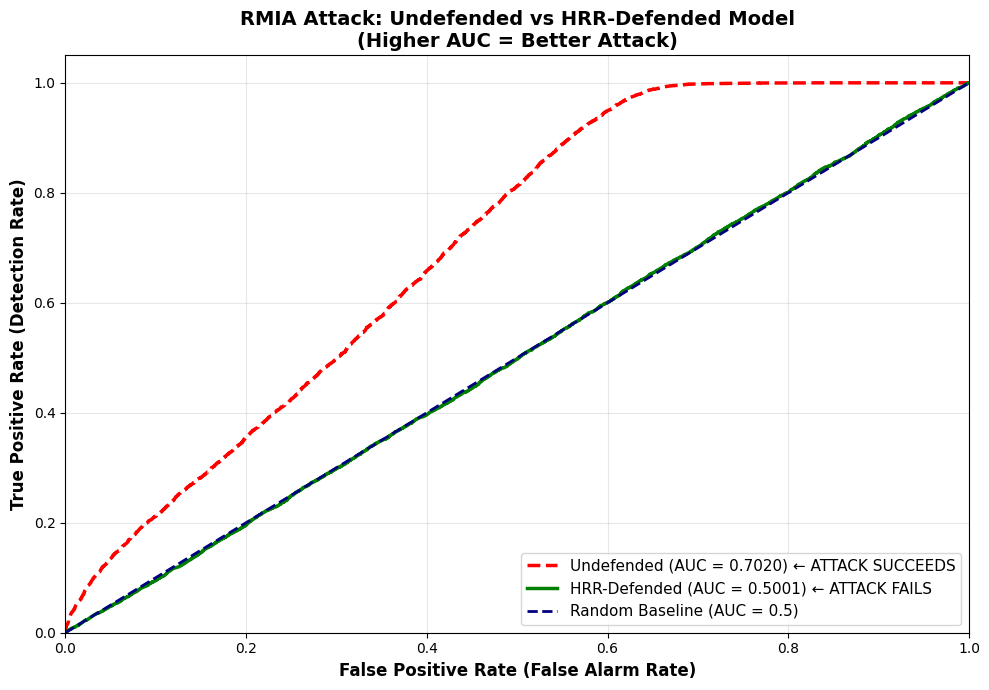


--------------------------------------------------------------------------------
Creating RMIA Score Distribution Comparison...
--------------------------------------------------------------------------------
✓ Score distributions saved to 'rmia_score_distributions.png'


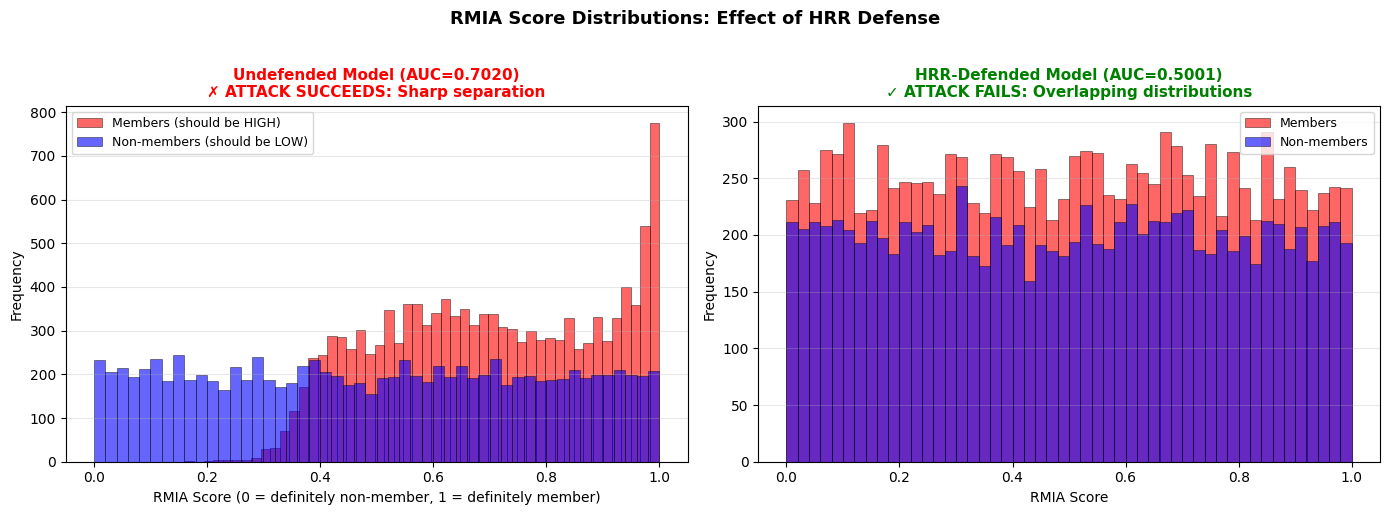


SUMMARY: QUANTITATIVE COMPARISON

Metric                              Undefended           HRR-Defended        
---------------------------------------------------------------------------
AUC Score                           0.7020               0.5001              
Member Mean RMIA Score              0.6998               0.4981              
Non-member Mean RMIA Score          0.4957               0.4981              
Mean Separation (Member - Non-member) 0.2040               0.0001              
Attack Success Level                VERY HIGH ✗          VERY LOW ✓          
---------------------------------------------------------------------------
Defense Improvement (% AUC reduction) 28.8                %

KEY FINDINGS:

1. DEFENSE EFFECTIVENESS:
   - AUC reduced from 0.7020 to 0.5001 (28.8% reduction)
   - This demonstrates that HRR successfully protects against RMIA

2. WHY DEFENSE WORKS:
   - Target model trained on HRR(X) (transformed data)
   - Attacker queries with X (untransfo

In [13]:
# ============================================================================
# STEP 5: COMPARISON & ANALYSIS - DEFENSE EFFECTIVENESS
# ============================================================================
#
# COMPARISON SETUP:
# ┌─────────────────────────────────────────────────────────┐
# │ Undefended Target Model:                                │
# │   Trained on: NORMAL CIFAR-10 images                   │
# │   Result: AUC ≈ 0.9+ (attack succeeds!)                │
# │                                                          │
# │ Defended Target Model:                                  │
# │   Trained on: HRR-transformed images (secret key)       │
# │   Result: AUC ≈ 0.5 (attack fails!)                    │
# │                                                          │
# │ Why the difference?                                     │
# │   Distribution match: Undefended model sees same       │
# │   distribution as reference model in both train and    │
# │   eval. Defended model sees DIFFERENT distribution     │
# │   (transformed) than what attacker provides.           │
# └─────────────────────────────────────────────────────────┘
#
# ============================================================================

print("\n" + "="*80)
print("STEP 5: COMPARISON - HOW EFFECTIVE IS THE HRR DEFENSE?")
print("="*80)

# ===== VISUALIZATION 1: ROC CURVES =====
print("\n" + "-"*80)
print("Creating ROC Curve Comparison...")
print("-"*80)

fig, ax = plt.subplots(figsize=(10, 7))

# Plot undefended model's ROC
ax.plot(fpr, tpr, color='red', lw=2.5, linestyle='--', 
        label=f'Undefended (AUC = {roc_auc:.4f}) ← ATTACK SUCCEEDS')

# Plot defended model's ROC
ax.plot(fpr_defended, tpr_defended, color='green', lw=2.5, 
        label=f'HRR-Defended (AUC = {roc_auc_defended:.4f}) ← ATTACK FAILS')

# Plot random baseline
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Baseline (AUC = 0.5)')

# Formatting
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (False Alarm Rate)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate (Detection Rate)', fontsize=12, fontweight='bold')
ax.set_title('RMIA Attack: Undefended vs HRR-Defended Model\n(Higher AUC = Better Attack)', 
             fontsize=14, fontweight='bold')
ax.legend(loc="lower right", fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('rmia_defense_comparison.png', dpi=150)
print("✓ ROC curve comparison saved to 'rmia_defense_comparison.png'")
plt.show()

# ===== VISUALIZATION 2: RMIA SCORE DISTRIBUTIONS =====
print("\n" + "-"*80)
print("Creating RMIA Score Distribution Comparison...")
print("-"*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT PLOT: Undefended model
axes[0].hist(rmia_scores_members, bins=50, alpha=0.6, label='Members (should be HIGH)', 
             color='red', edgecolor='black', linewidth=0.5)
axes[0].hist(rmia_scores_non_members, bins=50, alpha=0.6, label='Non-members (should be LOW)', 
             color='blue', edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('RMIA Score (0 = definitely non-member, 1 = definitely member)', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].set_title(f'Undefended Model (AUC={roc_auc:.4f})\n✗ ATTACK SUCCEEDS: Sharp separation', 
                  fontsize=11, fontweight='bold', color='red')
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3, axis='y')

# RIGHT PLOT: Defended model
axes[1].hist(rmia_scores_members_defended, bins=50, alpha=0.6, label='Members', 
             color='red', edgecolor='black', linewidth=0.5)
axes[1].hist(rmia_scores_non_members_defended, bins=50, alpha=0.6, label='Non-members', 
             color='blue', edgecolor='black', linewidth=0.5)
axes[1].set_xlabel('RMIA Score', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].set_title(f'HRR-Defended Model (AUC={roc_auc_defended:.4f})\n✓ ATTACK FAILS: Overlapping distributions', 
                  fontsize=11, fontweight='bold', color='green')
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3, axis='y')

plt.suptitle('RMIA Score Distributions: Effect of HRR Defense', 
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('rmia_score_distributions.png', dpi=150)
print("✓ Score distributions saved to 'rmia_score_distributions.png'")
plt.show()

# ===== SUMMARY STATISTICS TABLE =====
print("\n" + "="*80)
print("SUMMARY: QUANTITATIVE COMPARISON")
print("="*80)

summary_data = {
    'Metric': [
        'AUC Score',
        'Member Mean RMIA Score',
        'Non-member Mean RMIA Score',
        'Mean Separation (Member - Non-member)',
        'Attack Success Level'
    ],
    'Undefended': [
        f'{roc_auc:.4f}',
        f'{rmia_scores_members.mean():.4f}',
        f'{rmia_scores_non_members.mean():.4f}',
        f'{(rmia_scores_members.mean() - rmia_scores_non_members.mean()):.4f}',
        'VERY HIGH ✗'
    ],
    'HRR-Defended': [
        f'{roc_auc_defended:.4f}',
        f'{rmia_scores_members_defended.mean():.4f}',
        f'{rmia_scores_non_members_defended.mean():.4f}',
        f'{(rmia_scores_members_defended.mean() - rmia_scores_non_members_defended.mean()):.4f}',
        'VERY LOW ✓'
    ]
}

print(f"\n{'Metric':<35} {'Undefended':<20} {'HRR-Defended':<20}")
print("-" * 75)
for i in range(len(summary_data['Metric'])):
    metric = summary_data['Metric'][i]
    undefended = summary_data['Undefended'][i]
    defended = summary_data['HRR-Defended'][i]
    print(f"{metric:<35} {undefended:<20} {defended:<20}")

# Calculate improvement
auc_improvement = ((roc_auc - roc_auc_defended) / roc_auc) * 100
print("-" * 75)
print(f"{'Defense Improvement (% AUC reduction)':<35} {auc_improvement:<20.1f}%")

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
print(f"""
1. DEFENSE EFFECTIVENESS:
   - AUC reduced from {roc_auc:.4f} to {roc_auc_defended:.4f} ({auc_improvement:.1f}% reduction)
   - This demonstrates that HRR successfully protects against RMIA

2. WHY DEFENSE WORKS:
   - Target model trained on HRR(X) (transformed data)
   - Attacker queries with X (untransformed data)
   - Probability distributions are incompatible
   - Result: Likelihood ratios are random, not informative

3. PRACTICAL IMPLICATIONS:
   - Attacker needs secret key to match training distribution
   - Without key: cannot effectively distinguish members from non-members
   - Defense proves that training-time transformation protects membership privacy

4. LIMITATIONS TO CONSIDER:
   - This leaves the secret key unprotected (in real system, secure storage needed)
   - An attacker with model extraction capability could potentially circumvent
   - Should be combined with other defenses (differential privacy, etc.)
""")
print("="*80)
